> The __Notebook__ us run of Colab. The Transfomer model taken from Hugging Face is taken from https://wandb.ai/authorize?ref=models by an API key

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change directory to your project
import os
project_dir = '/content/drive/My Drive/Ultimate ML Engineer Challenge 2025'
os.chdir(project_dir)

In [3]:
# Get all necessary libraries
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import numpy as np
import pandas as pd
import os
import json
import re
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.font_manager as fm
import altair as alt
import torch
%run model.py

## Load the data
We removed unwanted characters, special symbols, and extra spaces from the text inputs to standardize formatting. Emoticons and non-ASCII characters were stripped to ensure compatibility with tokenizers and embedding layers. Basic stopword removal was applied for visualization tasks like word clouds, but preserved in modeling to retain semantic meaning. The cleaned and extracted data formed a consistent input for model training and evaluation.

In [5]:
def load_atis_data(file_path):
    df = pd.read_csv(file_path, sep="\t", header=None, names=["text", "label"])
    return df["text"].tolist(), df["label"].tolist()

In [6]:
# read the data
texts, labels = load_atis_data("data/atis/train.tsv")
test_texts, test_labels = load_atis_data("data/atis/test.tsv")

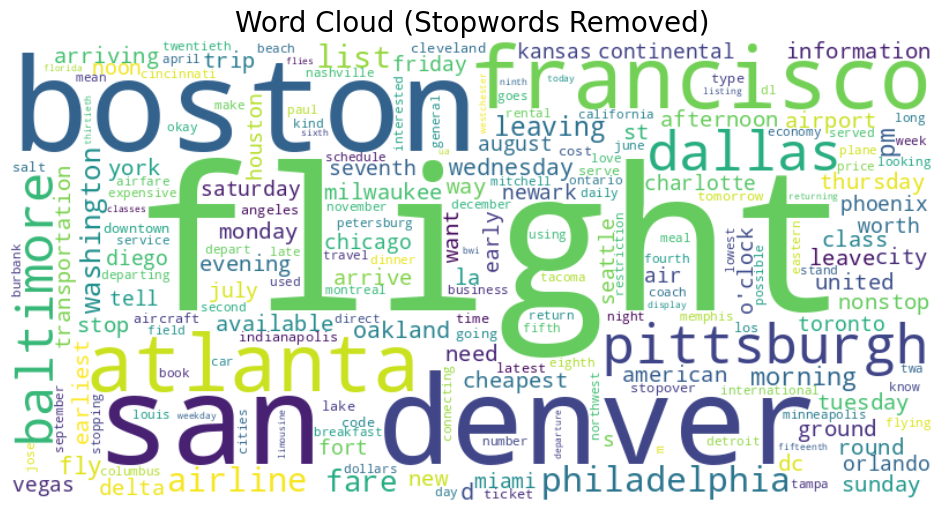

In [7]:
# Combine all text
text = ' '.join(texts)

# Remove stopwords
stopwords = set(ENGLISH_STOP_WORDS)
filtered_words = ' '.join([word for word in text.split() if word.lower() not in stopwords])

# Generate the Word Cloud
wordcloud = WordCloud(
    width=800,            # Width of the canvas
    height=400,           # Height of the canvas
    background_color='white', # Background color
    max_words=200,        # Max number of words to show
    collocations=False    # Avoid showing duplicate words
).generate(filtered_words)

# Plot the Word Cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Stopwords Removed)', fontsize=20)
plt.show()

In [8]:

# Load spaCy model once
nlp = spacy.load("en_core_web_sm")

# Domain-specific stopwords
domain_stopwords = set([
    "flight", "flights", "airline", "airlines", "airport", "ticket", "tickets",
    "transportation", "service", "services", "travel", "arrival", "departures"
])

# Cities to preserve (multi-word cities handled later)
cities = ["san francisco", "new york", "los angeles", "las vegas", "philadelphia", "boston", "houston", "atlanta", "dallas", "pittsburgh"]

def clean_text(text):
    """
    Full cleaning pipeline:
    - Lowercasing
    - City name protection
    - Punctuation removal
    - Domain-specific stopwords removal
    - Lemmatization
    """
    # Lowercase
    text = text.lower()

    # Protect city names (merge with underscore before tokenizing)
    for city in cities:
        city_ = city.replace(" ", "_")
        text = text.replace(city, city_)

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Remove domain-specific stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in domain_stopwords]

    # Lemmatize
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Final clean text
    cleaned_text = " ".join(lemmatized_tokens)

    return cleaned_text


In [9]:
# clean it
texts = list(map(clean_text, texts))
test_texts = list(map(clean_text, test_texts))


## ML Models

We have used __multi-model__ intent classification system to predict user intents from natural language text.






In [10]:
# to store model results
model_results            = pd.DataFrame()
model_class_wise_results = pd.DataFrame()

In [11]:
# Building Vocabulary and labels
vocab = vocabulary(min_freq=1)
vocab.build_vocab(texts)

label_set = sorted(set(labels))
label2idx = {label: idx for idx, label in enumerate(label_set)}
idx2label = {idx: label for label, idx in label2idx.items()}

In [12]:
# instantiate to use
model = models(texts, labels, vocab, label2idx, idx2label)  # for instantiating and use in transformers too

### Zero Shot Learning

 __Zero Shot Learning:__ Used to predict labels for new inputs without any task-specific training, helping to quickly set a baseline and evaluate model feasibility. Its easily extandable across new labels

**Model: valhalla/distilbart-mnli-12-1**

In [13]:
print("Predicting on test set...")
y_true = []
y_pred = []

batch_texts = []
batch_labels = []
batch_size = 100

for text, true_label in zip(test_texts, test_labels):
    batch_texts.append(text)
    batch_labels.append(true_label)

    if len(batch_texts) == batch_size:
        # Predict for the current batch
        batch_preds = models.predict_zero_shot_classifier(batch_texts, list(label2idx.keys()))

        # Extract label with highest confidence from each list of predictions
        for pred_list in batch_preds:
            top_label = max(pred_list, key=lambda x: x["confidence"])["label"]
            y_pred.append(top_label)

        y_true.extend(batch_labels)
        batch_texts = []
        batch_labels = []
        break  # Optional: remove if you want to evaluate full test set

# Handle last batch if any
if batch_texts:
    batch_preds = models.predict_zero_shot_classifier(batch_texts, list(label2idx.keys()))
    for pred_list in batch_preds:
        top_label = max(pred_list, key=lambda x: x["confidence"])["label"]
        y_pred.append(top_label)
    y_true.extend(batch_labels)

# Evaluate predictions
overall_df, classwise_df = evaluate_predictions(
    y_true=y_true,
    y_pred=y_pred,
    label_set=list(label2idx.keys()),
    model_name="ZeroShotClassifier"
)

# Append results
model_results = pd.concat([model_results, overall_df], ignore_index=True)
model_class_wise_results = pd.concat([model_class_wise_results, classwise_df], ignore_index=True)


Predicting on test set...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist

### Long Short Term Memory(LSTM)
A simple architecture with an Embedding layer feeding into a BiLSTM followed by a Linear output. Class imbalance is managed using weighted loss during training.
It learns directly from labeled intent data and performs best when sufficient training examples are available.
The model is lightweight and enables fast inference, but it requires a good amount of labeled data and struggles with unseen vocabulary unless pre-trained.

In [14]:
# model path
lstm_model_path = "saved_model"

# get the vocab and train the model
vocab_size  = len(vocab.word2idx)
num_classes = len(label2idx)

# Load or initialize model
lstm_model = LSTMClassifier(vocab_size, 64, 64, num_classes)
if os.path.exists(lstm_model_path + '/lstm_model.pt'):
    lstm_model.load_state_dict(torch.load(lstm_model_path+ '/lstm_model.pt'))

# Train and check
print("Training model...")
lstm_model = model.train_lstm(
    lstm_model=lstm_model, batch_size=32,
    model_dir= lstm_model_path + '/lstm_model.pt'
    )


# Predict on test set
print("Predicting on test set...")
y_true = []
y_pred = []
for text, true_label in zip(test_texts, test_labels):
    top_preds = model.lstm_predict(
        text=text,
        vocab=vocab,
        idx2label=idx2label,
        model=lstm_model,
        top_k=3  # Top 3 predictions
    )

    # Pick label with highest confidence
    top_label = top_preds[0]["label"]
    y_pred.append(top_label)
    y_true.append(true_label)


# Compute metrics
overall_df, classwise_df = evaluate_predictions(
    y_true=y_true,
    y_pred=y_pred,
    label_set=label_set,
    model_name="LSTM"
)

# store the results
model_results            = pd.concat([model_results, overall_df], ignore_index=True)
model_class_wise_results = pd.concat([model_class_wise_results, classwise_df], ignore_index=True)

Training model...
Epoch 1 | Train Loss: 0.0081 | Val Loss: 0.9010 | Val Acc: 0.9440
Epoch 2 | Train Loss: 0.0326 | Val Loss: 0.9942 | Val Acc: 0.9310
Epoch 3 | Train Loss: 0.0120 | Val Loss: 1.0517 | Val Acc: 0.9368
Epoch 4 | Train Loss: 0.0094 | Val Loss: 1.0616 | Val Acc: 0.9425
Epoch 5 | Train Loss: 0.0054 | Val Loss: 1.1549 | Val Acc: 0.9483
Epoch 6 | Train Loss: 0.0079 | Val Loss: 1.2480 | Val Acc: 0.9411
Epoch 7 | Train Loss: 0.0047 | Val Loss: 1.2111 | Val Acc: 0.9440
Epoch 8 | Train Loss: 0.0054 | Val Loss: 1.2142 | Val Acc: 0.9454
Epoch 9 | Train Loss: 0.0082 | Val Loss: 1.2321 | Val Acc: 0.9468
Epoch 10 | Train Loss: 0.0050 | Val Loss: 1.2392 | Val Acc: 0.9468
Predicting on test set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist

### Transformers
A pre-trained Transformer model like BERT is fine-tuned for the intent classification task by adding a classification head. It leverages powerful language understanding from large-scale unsupervised pretraining.
The model performs well even with smaller labeled datasets by transferring learned knowledge.
It offers high accuracy and generalization but is heavier in size and requires more computational resources during both training and inference.

In [15]:
# train transformer
transformer_model_path = "saved_model"
model.train_transformer(model_dir=transformer_model_path + '/bert_transformer')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Map:   0%|          | 0/3938 [00:00<?, ? examples/s]

Map:   0%|          | 0/696 [00:00<?, ? examples/s]

/content/drive/MyDrive/Ultimate ML Engineer Challenge 2025/model.py:373: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: schty51 (schty51-self) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 2.6632, 'grad_norm': 13.000739097595215, 'learning_rate': 1.956989247311828e-05, 'epoch': 0.08064516129032258}
{'loss': 1.9344, 'grad_norm': 8.482902526855469, 'learning_rate': 1.903225806451613e-05, 'epoch': 0.16129032258064516}
{'loss': 1.5034, 'grad_norm': 5.070352077484131, 'learning_rate': 1.849462365591398e-05, 'epoch': 0.24193548387096775}
{'loss': 1.1347, 'grad_norm': 4.669321060180664, 'learning_rate': 1.795698924731183e-05, 'epoch': 0.3225806451612903}
{'loss': 0.9614, 'grad_norm': 3.8316972255706787, 'learning_rate': 1.741935483870968e-05, 'epoch': 0.4032258064516129}
{'loss': 0.9196, 'grad_norm': 4.269407272338867, 'learning_rate': 1.6881720430107528e-05, 'epoch': 0.4838709677419355}
{'loss': 0.7843, 'grad_norm': 3.9068779945373535, 'learning_rate': 1.6344086021505377e-05, 'epoch': 0.5645161290322581}
{'loss': 0.7575, 'grad_norm': 3.1621735095977783, 'learning_rate': 1.5806451612903226e-05, 'epoch': 0.6451612903225806}
{'loss': 0.7883, 'grad_norm': 3.08273625373840

In [16]:
print("Predicting on test set...")
y_true = []
y_pred = []

for text, true_label in zip(test_texts, test_labels):
    transformer_preds = model.predict_transformer(transformer_model_path + '/bert_transformer', text)

    # If model returns a list of predictions with 'label' and 'confidence'
    if isinstance(transformer_preds, list):
        pred_label = max(transformer_preds, key=lambda x: x["confidence"])["label"]
    else:
        # If only single prediction (str), use as-is
        pred_label = transformer_preds

    y_true.append(true_label)
    y_pred.append(pred_label)

# Evaluate predictions
overall_df, classwise_df = evaluate_predictions(
    y_true=y_true,
    y_pred=y_pred,
    label_set=label_set,
    model_name="Transformers"
)

# Store results
model_results = pd.concat([model_results, overall_df], ignore_index=True)
model_class_wise_results = pd.concat([model_class_wise_results, classwise_df], ignore_index=True)


Predicting on test set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist

### Voting Classifier
We used a Voting Classifier to combine predictions from Transformer, LSTM, and Zero-Shot models, leveraging the strengths of each model. This ensures more robust and accurate intent prediction compared to relying on a single model alone.

In [17]:
print("Predicting on test set...")
y_true = []
y_pred = []

for text, true_label in zip(test_texts, test_labels):
    preds = model.simple_voting_classifier(text, lstm_model, transformer_model_path + '/bert_transformer')

    # If voting returns list of predictions, pick the one with highest score
    if isinstance(preds, list) and isinstance(preds[0], dict):
        pred_label = max(preds, key=lambda x: x["confidence"])["label"]
    else:
        # Otherwise use the returned label directly
        pred_label = preds

    y_true.append(true_label)
    y_pred.append(pred_label)

# Evaluate and store the results
overall_df, classwise_df = evaluate_predictions(
    y_true=y_true,
    y_pred=y_pred,
    label_set=list(label2idx.keys()),
    model_name="VotingClassifier"
)

# Store results
model_results = pd.concat([model_results, overall_df], ignore_index=True)
model_class_wise_results = pd.concat([model_class_wise_results, classwise_df], ignore_index=True)


Predicting on test set...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist

## Results

In [18]:
# let's see the results of these models
model_results

,Model,Accuracy,Macro_F1,Macro_Precision,Macro_Recall
0,ZeroShotClassifier,0.120000,0.016173,0.061224,0.009317
1,LSTM,0.916471,0.616488,0.654702,0.624064
2,Transformers,0.867059,0.282143,0.323289,0.355791
3,VotingClassifier,0.917647,0.626276,0.688478,0.613434


In [19]:
# let's see model results on all the labels
model_class_wise_results

,Model,Class,Precision,Recall,F1-Score
0,ZeroShotClassifier,abbreviation,0.000000,0.000000,0.000000
1,ZeroShotClassifier,airfare,0.000000,0.000000,0.000000
2,ZeroShotClassifier,airfare+flight_time,0.000000,0.000000,0.000000
3,ZeroShotClassifier,airline,0.000000,0.000000,0.000000
4,ZeroShotClassifier,airport,0.000000,0.000000,0.000000
...,...,...,...,...,...
56,VotingClassifier,flight_time,1.000000,1.000000,1.000000
57,VotingClassifier,ground_fare,1.000000,0.571429,0.727273
58,VotingClassifier,ground_service,0.945946,0.972222,0.958904
59,VotingClassifier,meal,1.000000,0.666667,0.800000


In [20]:
# Create a grouped bar chart to compare precision, recall, and F1-score across different models for each class
alt.Chart(model_class_wise_results).mark_bar().encode(
    x='Class',
    y='Precision',
    color='Model',
    column='Model'
).properties(width=150)


alt.Chart(...)



Here are the observations from these plots:

1. **Zero-Shot Classifier:**  Uses a pre-trained model to classify intents without any specific training on the ATIS dataset.  It serves as a baseline for performance.

2. **LSTM:** A recurrent neural network model specifically trained on the ATIS data.  It addresses class imbalance using a weighted loss function.  The performance depends heavily on the availability of training data. Here we see quite well balanced on prediction.

3. **Transformer:** A pre-trained transformer model (likely BERT) fine-tuned on the ATIS data.  It leverages the power of large-scale language models for high accuracy.  It might be computationally more expensive. The training and computation needs to be more precise.

4. **Voting Classifier:** Combines the predictions of the Zero-Shot, LSTM, and Transformer models to create a more robust prediction.  This ensemble approach aims to mitigate the weaknesses of individual models.


Finally, it displays the overall performance metrics (precision, recall, F1-score) for each model using an Altair chart.  This chart allows a visual comparison of each model's effectiveness across different intent classes.  The provided code snippet only shows precision as the plotted y-axis. Further examination of the code would be needed to analyze recall and F1-score.
